# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [25]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact
%matplotlib inline

In [2]:
# Initialize the Panel Extensions (for Plotly)
#import panel as pn
#pn.extension("plotly")

In [3]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [4]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

# Load neighbourhoods coordinates data
file_path = Path("Data/toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [5]:
# Calculate the sum number of dwelling types units per year

# Use iloc to include only the dwelling types columns and no additional columns
yearly_dwelling_types = to_data.iloc[:, 1:9].groupby("year").sum()

# Slice data for Year by 2001, 2006, 2011, and 2016
yearly_dwelling_types_1 = yearly_dwelling_types.loc[2001]
yearly_dwelling_types_2 = yearly_dwelling_types.loc[2006]
yearly_dwelling_types_3 = yearly_dwelling_types.loc[2011]
yearly_dwelling_types_4 = yearly_dwelling_types.loc[2016]

In [6]:
# Calculate the average monthly shelter costs for owned and rented dwellings

# Use iloc to include the shelter costs for owned and rented dwellings
average_shelter_costs = to_data.iloc[:, 10:12].groupby("year").mean()

# Slice data for Year by 2001, 2006, 2011, and 2016
average_shelter_costs_1 = average_shelter_costs["shelter_costs_owned"]
average_shelter_costs_2 = average_shelter_costs["shelter_costs_rented"]

In [7]:
# Calculate the average house value per year
avg_house_value = to_data["average_house_value"].groupby("year").mean()

In [8]:
# Getting the data from the top 10 expensive neighbourhoods

# Create a new DataFrame with the mean house values by neighbourhood per year
yearly_neighbourhood_value = to_data[["neighbourhood", "average_house_value"]]

# Create a list containing the different neighbourhoods
neighbourhood_list = to_data["neighbourhood"].unique()

In [9]:
# Fetch the data of all dwelling types per year
yearly_neighbourhood_dwelling = to_data.iloc[:, 0:9] 

In [10]:
# Getting the data from the top 10 expensive neighbourhoods
# First, get the mean of the average_house_value by neighbourhood
neighbourhood_house_value_avg = yearly_neighbourhood_value.groupby("neighbourhood").mean()
# Then, get the top 10 most expensive neighbourhoods using nlargest() which sorts by descending order
top_10_most_enpensive_neighbourhoods = neighbourhood_house_value_avg.nlargest(10, ["average_house_value"])

In [11]:
# Calculate the mean values for each neighborhood
# This was calculated above and saved as follows:
neighbourhood_house_value_avg

# Join the average values with the neighbourhood locations

avg_values = neighbourhood_house_value_avg
neighbourhood_with_index = df_neighbourhood_locations.set_index("neighbourhood")
neighbourhood_values = (
    pd.concat([avg_values, neighbourhood_with_index], axis=1, sort=True)
    .dropna()
    .reset_index()
)

### Panel Visualization Functions

In [12]:
# Define Panel visualization functions
def neighbourhood_map():
    """Neighbourhood Map"""
    # Create a scatter mapbox to analyze neighbourhood info
    neighbourhood_values_plot = px.scatter_mapbox(
        neighbourhood_values,
        lat="lat",
        lon="lon",
        size="average_house_value",
        color="average_house_value",
        color_continuous_scale=px.colors.cyclical.IceFire,
        title="Average House Values in Toronto",
        zoom=9,
        width=1100,
        height=500
    )
    return neighbourhood_values_plot

In [13]:
def create_bar_chart(data, title, xlabel, ylabel, color):
    """
    Create a barplot based in the data argument.
    """
    fig = plt.figure()
    barchart = data.plot.bar(color=color)
    barchart.set_xlabel(xlabel)
    barchart.set_ylabel(ylabel)
    barchart.set_title(title)
    plt.close(fig)
    return fig
    
def create_line_chart(data, title, xlabel, ylabel, color):
    """
    Create a line chart based in the data argument.
    """
    fig = plt.figure()
    linechart = data.plot.line(color=color)
    linechart.set_xlabel(xlabel)
    linechart.set_ylabel(ylabel)
    linechart.set_title(title)
    plt.close(fig)
    return fig

def average_house_value():
    """Average house values per year."""
    # Plot the average house value per year as a line chart
    line_plot = create_line_chart(avg_house_value, "Average House Value in Toronto", "Year", "Avg House Value", "#4E8FCB")
    return line_plot
    
def average_value_by_neighbourhood(neighbourhood):
    """Average house values by neighbourhood."""
    # Obtain the specific neighbourhood's average house values
    neighbourhood_avg_values = yearly_neighbourhood_value.loc[yearly_neighbourhood_value["neighbourhood"] == neighbourhood]
    line_hvplot = neighbourhood_avg_values.hvplot.line(xlabel="Year", ylabel="Avg. House Value").opts(title="neighbourhood: " + neighbourhood, yformatter="%.0f", color="#4E8FCB")
    return line_hvplot
    
def number_dwelling_types(neighbourhood):
    """Number of dwelling types per year"""
    # Obtain the specific neighbourhood's dwelling types
    yearly_neighbourhood_dwelling_total = yearly_neighbourhood_dwelling.loc[yearly_neighbourhood_dwelling["neighbourhood"] == neighbourhood]
    bar_hvplot = yearly_neighbourhood_dwelling_total.hvplot.bar(xlabel="Year", ylabel="Dwelling Type Units", rot=90).opts(title="neighbourhood: " + neighbourhood, yformatter="%.0f", height=500)
    return bar_hvplot

#def average_house_value_snapshot():
#    """Average house value for all Toronto's neighbourhoods per year."""

    # YOUR CODE HERE!

def top_most_expensive_neighbourhoods():
    """Top 10 most expensive neighbourhoods."""
    bar_plot = top_10_most_enpensive_neighbourhoods.hvplot.bar(xlabel="Neighbourhood", ylabel="Avg. House Value", rot=90).opts(title="Top 10 Expensive Neighbourhoods in Toronto", yformatter="%.0f", height=500, color="#4E8FCB")
    return bar_plot

#def sunburts_cost_analysis():
#    """Sunburst chart to conduct a costs analysis of most expensive neighbourhoods in Toronto per year."""
    
    # YOUR CODE HERE!

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Row
                [0] Column
                    [0] Column()
                    [1] Row
                        [0] Plotly(Figure, name='interactive01554')
        [1] Column
            [0] Row
                [0] Matplotlib(Figure)
                [1] Matplotlib(Figure)
            [1] Row
                [0] Matplotlib(Figure)
                [1] Matplotlib(Figure)
        [2] Column
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [3] Column
            [0] Column
                [0] Column
                    [0] Select(name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North')
                [1] Row
                    [0] HoloViews(Curve, name='interactive01582')
            [1] Column
                [0] Column
                    [0] Select(name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North')
                [1] Row
                    [0] HoloViews(Bars, name='interactive01710')
        [4] Row
            [0] HoloViews(Bars)
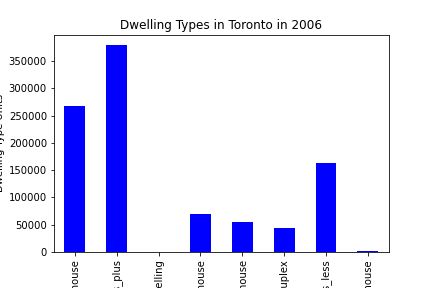
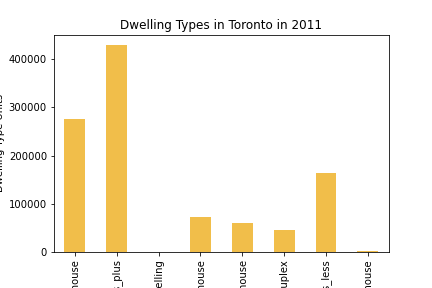
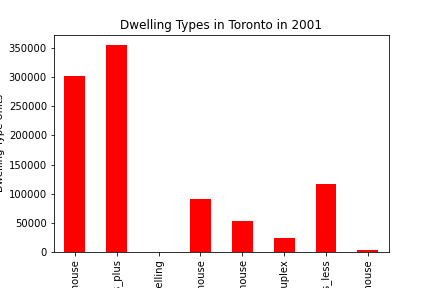
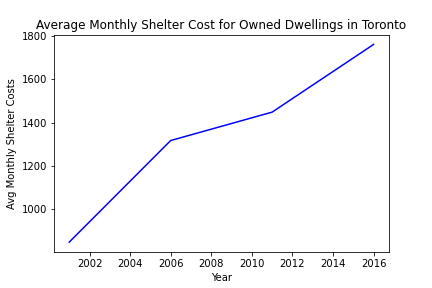
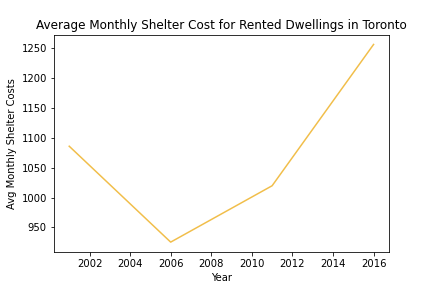
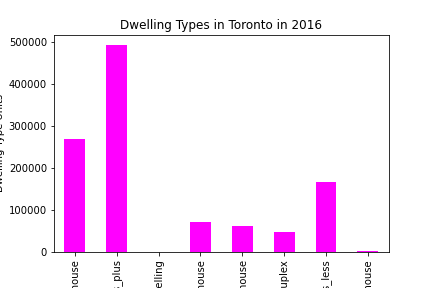
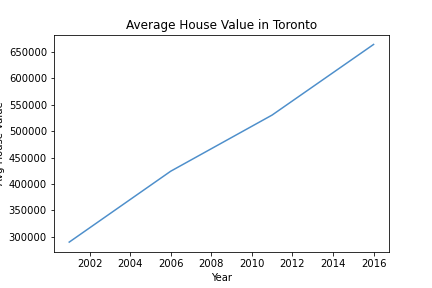

In [14]:
# Create a Title for the Dashboard
title = "## Real Estate Analysis of Toronto from 2001 to 2016"

# Define a welcome text
welcome_text = "This dashboard presents a visual analysis of historical house values, dwelling types per neighbourhood and dwelling costs in Toronto, Ontario according to census data from 2001 to 2016. You can navigate through the tabs above to explore more details about the evolution of the real estate market in Toronto across these years."
# Put the neighbourhood map in a row
neighbourhood_row = pn.Row(neighbourhood_map)

# Create a tab layout for the dashboard
# Create first tab column
welcome_column = pn.Column(welcome_text, neighbourhood_row)

# Bar chart for 2001
bar_chart_2001 = create_bar_chart(yearly_dwelling_types_1, "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")
# Bar chart for 2006
bar_chart_2006 = create_bar_chart(yearly_dwelling_types_2, "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")
# Bar chart for 2011
bar_chart_2011 = create_bar_chart(yearly_dwelling_types_3, "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "#F1BE4A")
# Bar chart for 2016
bar_chart_2016 = create_bar_chart(yearly_dwelling_types_4, "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

# Position two bar charts per row
row_of_bar_1 = pn.Row(bar_chart_2001, bar_chart_2006)
row_of_bar_2 = pn.Row(bar_chart_2011, bar_chart_2016)
# Put rows in a column
yearly_analysis_column = pn.Column(row_of_bar_1, row_of_bar_2)

# Line chart for owned dwellings
line_chart_1 = create_line_chart(average_shelter_costs_1, "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")
# Line chart for rented dwellings
line_chart_2 = create_line_chart(average_shelter_costs_2, "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "#F1BE4A")
# Line chart for average house value  
line_chart_3 = average_house_value()
# Put line charts in a column
shelter_costs_column = pn.Column(line_chart_1, line_chart_2, line_chart_3)

# Interactive line and bar charts for neighbourhood analysis
interactive_1 = interact(average_value_by_neighbourhood, neighbourhood=neighbourhood_list)
interactive_2 = interact(number_dwelling_types, neighbourhood=neighbourhood_list)
# Put interactive charts in a column
neighbourhood_analysis_column = pn.Column(interactive_1, interactive_2)

# Put expensive neighbourhoods chart in a row
top_expensive_neighbourhoods_row = pn.Row(top_most_expensive_neighbourhoods())


# Create the main dashboard
to_real_estate_dashboard_tabs = pn.Tabs(
    (
        "Welcome",
        welcome_column
    ),
    (
        "Yearly Market Analysis",
        yearly_analysis_column
    ),
    (
        "Shelter Costs Vs. House Value",
        shelter_costs_column
    ),
    (
        "Neighbourhood Analysis",
        neighbourhood_analysis_column
    ),
    (
        "Top Expensive Neighbourhoods",
        top_expensive_neighbourhoods_row
    )
)

to_real_estate_dashboard = pn.Column(title, to_real_estate_dashboard_tabs)

to_real_estate_dashboard

## Serve the Panel Dashboard

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Row
                [0] Column
                    [0] Column()
                    [1] Row
                        [0] Plotly(Figure, name='interactive01554')
        [1] Column
            [0] Row
                [0] Matplotlib(Figure)
                [1] Matplotlib(Figure)
            [1] Row
                [0] Matplotlib(Figure)
                [1] Matplotlib(Figure)
        [2] Column
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [3] Column
            [0] Column
                [0] Column
                    [0] Select(name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North')
                [1] Row
                    [0] HoloViews(Curve, name='interactive01582')
            [1] Column
                [0] Column
                    [0] Select(name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North')
                [1] Row
                    [0] HoloViews(Bars, name='interactive01710')
        [4] Row
            [0] HoloViews(Bars)
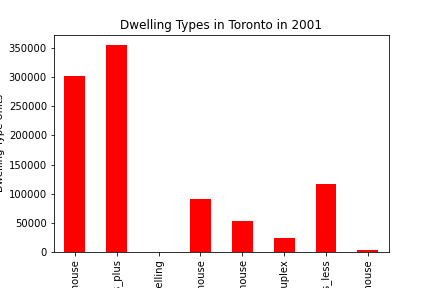
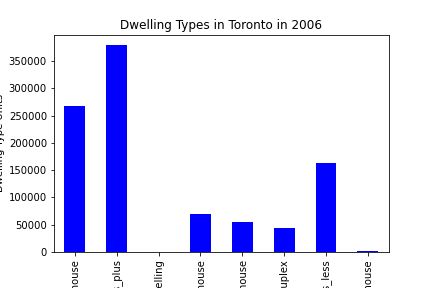
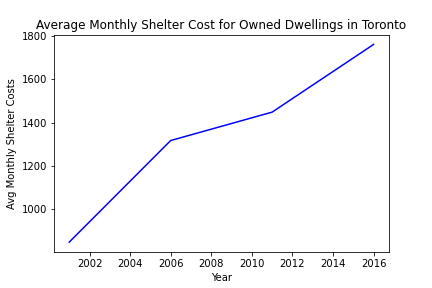
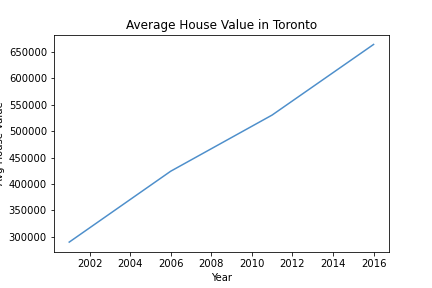
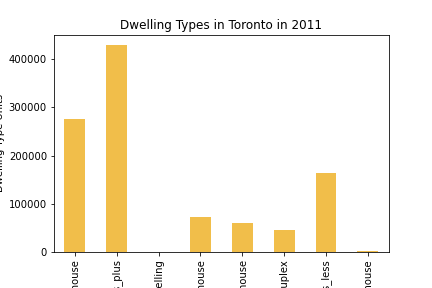
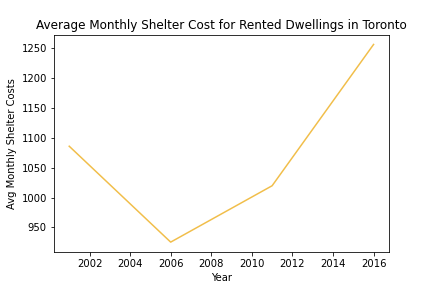
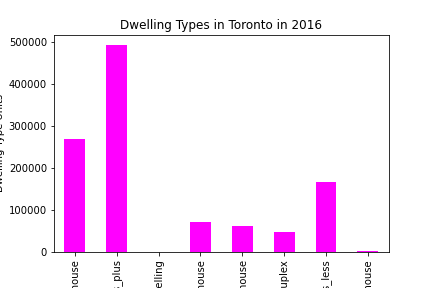

In [15]:
to_real_estate_dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [16]:
# neighbourhood_map().show()

In [17]:
# create_bar_chart(data, title, xlabel, ylabel, color)

# # Bar chart for 2001
# create_bar_chart(yearly_dwelling_types.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")

# # Bar chart for 2006
# create_bar_chart(df_dwelling_units.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")

# # Bar chart for 2011
# create_bar_chart(df_dwelling_units.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")

# # Bar chart for 2016
# create_bar_chart(df_dwelling_units.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

In [18]:
# create_line_chart(data, title, xlabel, ylabel, color)

# # Line chart for owned dwellings
# create_line_chart(df_avg_costs["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # Line chart for rented dwellings
# create_line_chart(df_avg_costs["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

In [19]:
# average_house_value()

In [20]:
# average_value_by_neighbourhood()

In [21]:
# number_dwelling_types()

In [22]:
# average_house_value_snapshot()

In [23]:
# top_most_expensive_neighbourhoods()

In [24]:
# sunburts_cost_analysis()